# ARIMA 모델로 주가 예측하기<span class="tocSkip">

# Stpe01. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

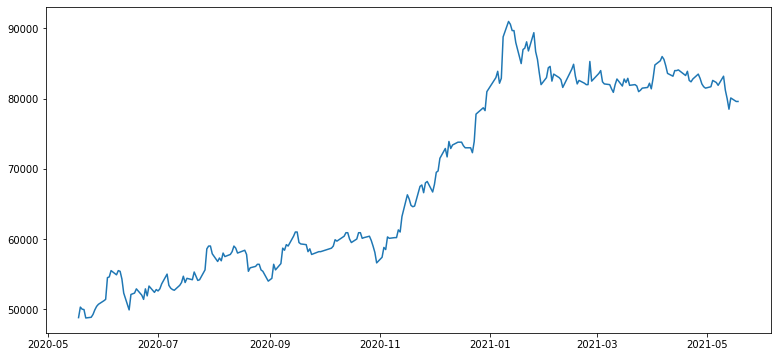

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# Stpe02. 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [ ]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

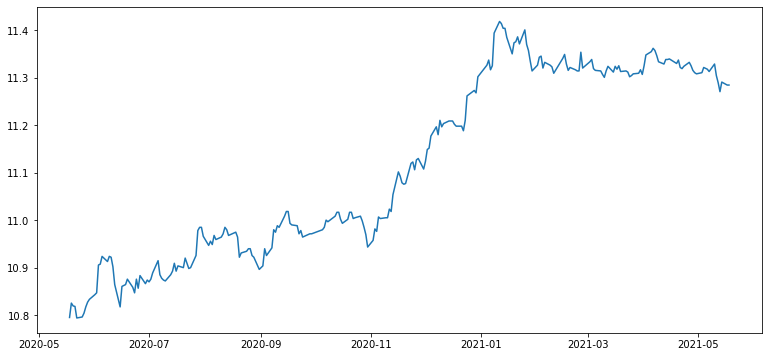

In [ ]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

# Stpe03. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [ ]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

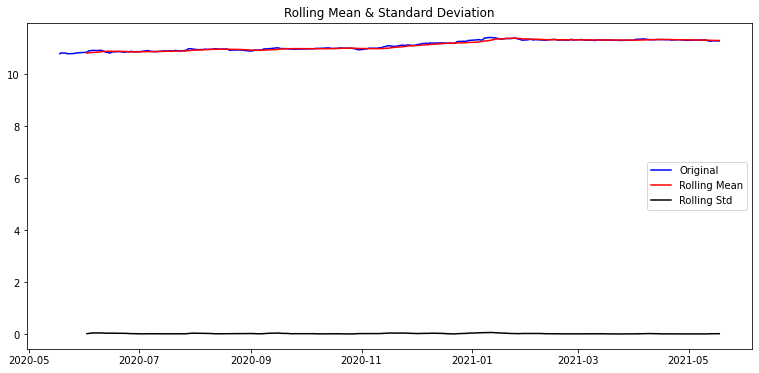

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


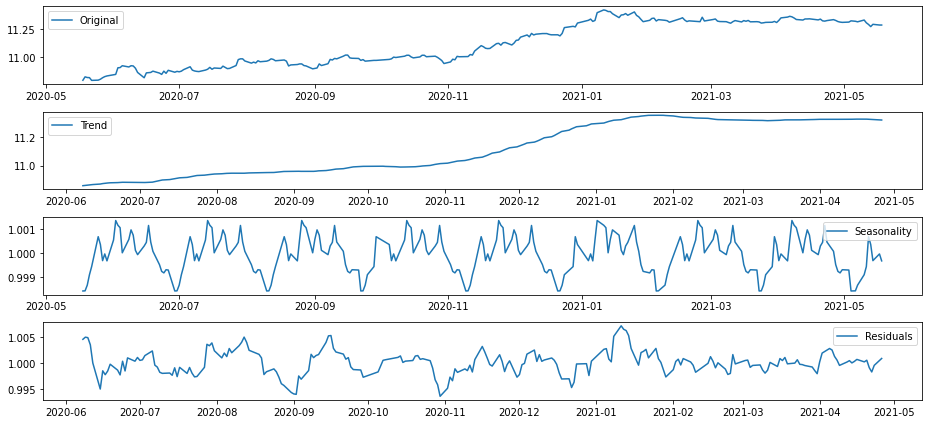

In [ ]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

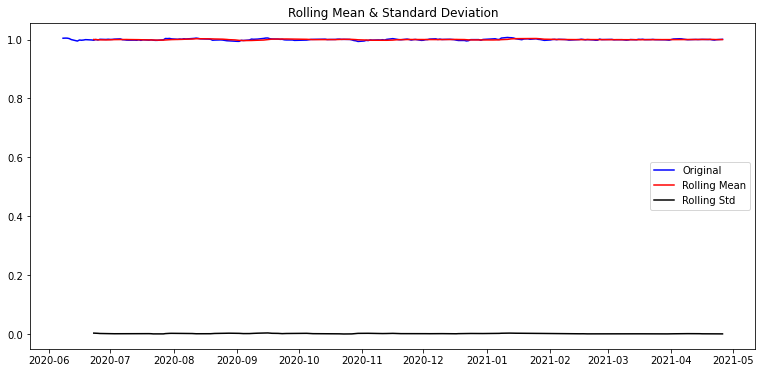

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [ ]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# Stpe04. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

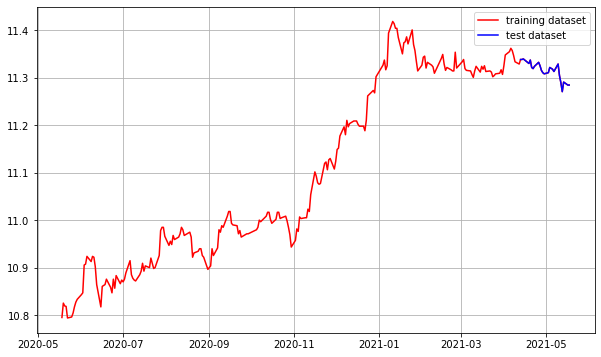

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# Stpe05. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

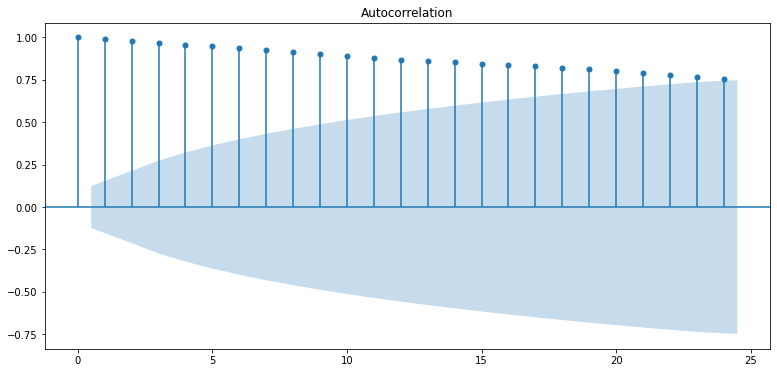

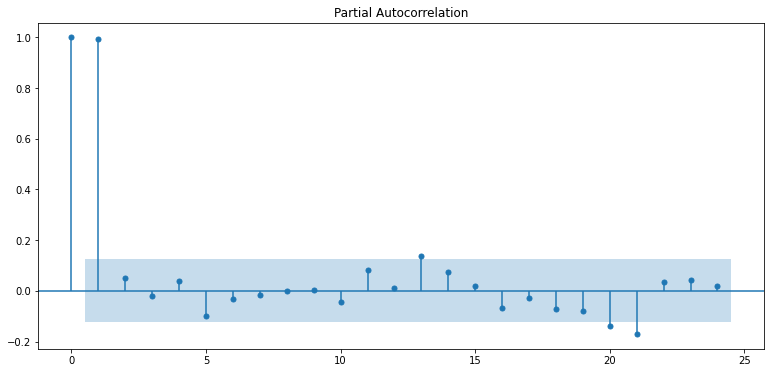

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


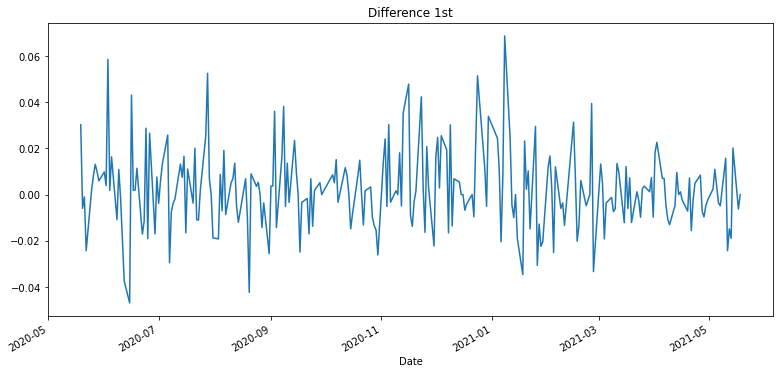

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


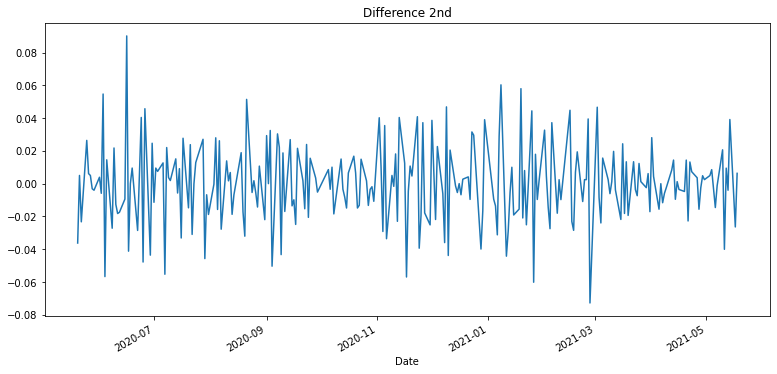

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# Stpe06. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 585.719
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 10 Feb 2022   AIC                          -1161.438
Time:                        03:47:00   BIC                          -1144.380
Sample:                             1   HQIC                         -1154.553
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      2.357      0.018       0.000       0.004
ar.L1.D.Close     0.7999      0.495      1.616      0.106      -0.170       1.770
ma.L1.D.Close    -0.7854      0.497     

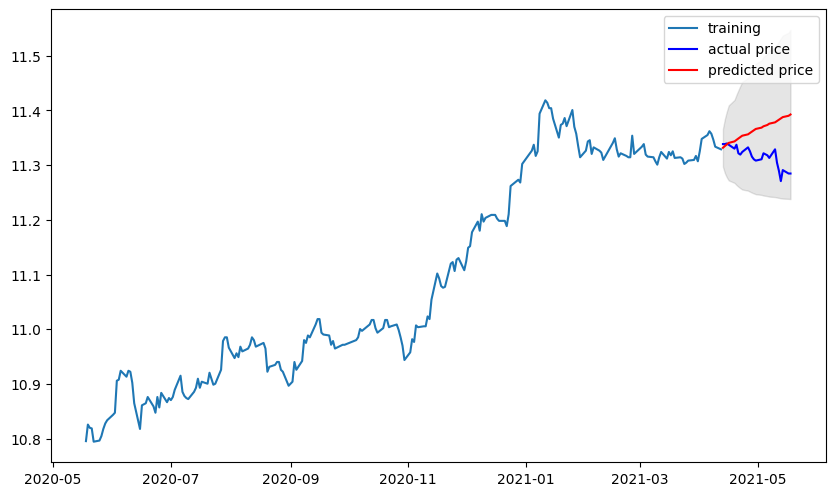

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  24810524.005755648
MAE:  4066.345899989174
RMSE:  4981.016362727154
MAPE: 5.02%


# Stpe07. 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기
- 여러 종목을 테스트해보기 위한 함수 구현

## 7-1. 함수 구현

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
def get_time_series_log(filename):
    # Time Series 생성
    dataset_dirpath = os.getenv('HOME') + '/aiffel/stock_prediction/data'
    dataset_filepath = os.path.join(dataset_dirpath, filename)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    # 결측치 처리
    if len(ts[ts.isna()]) > 0:
        ts = ts.interpolate(method='time')
    # 로그 변환
    return np.log(ts)

In [ ]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    rcParams['figure.figsize'] = 10, 6
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [ ]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def check_stationary(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)
    # 정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

In [ ]:
def time_series_decomposition(ts_log):
    # 시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

In [ ]:
# 학습, 테스트 데이터셋 분리
def split_train_test_data(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
def plot_acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

In [ ]:
# 차분 안정성 확인 -> d 구하기
def get_difference(ts_log):
    # 1차 차분 구하기
    plt.subplot(211)
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    # 혹시 필요한 경우 2차 차분 구하기
    plt.subplot(212)
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    print('Difference 1st:')
    augmented_dickey_fuller_test(diff_1)
    print('\nDifference 2nd:')
    augmented_dickey_fuller_test(diff_2)

In [ ]:
def arima_train_test(order):
    # Build and Train  Model
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    # Score
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

## 7-2. Microsoft

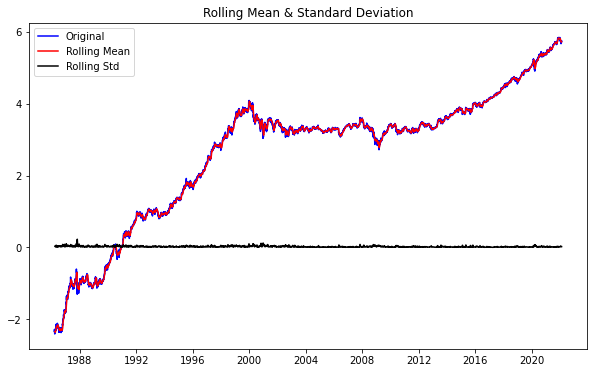

Results of Dickey-Fuller Test:
Test Statistic                   -2.777055
p-value                           0.061627
#Lags Used                        4.000000
Number of Observations Used    9048.000000
Critical Value (1%)              -3.431073
Critical Value (5%)              -2.861859
Critical Value (10%)             -2.566940
dtype: float64


In [ ]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('MSFT.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

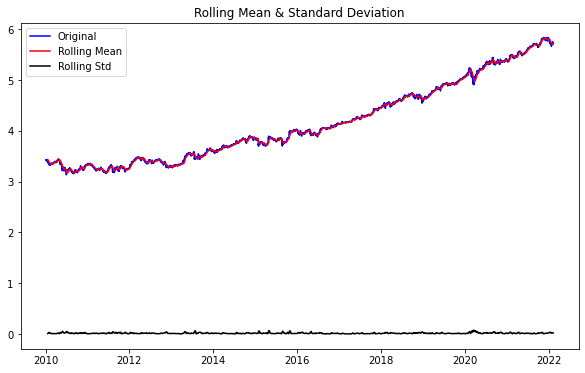

Results of Dickey-Fuller Test:
Test Statistic                    1.364578
p-value                           0.996947
#Lags Used                       15.000000
Number of Observations Used    3032.000000
Critical Value (1%)              -3.432509
Critical Value (5%)              -2.862494
Critical Value (10%)             -2.567278
dtype: float64


In [ ]:
# 기간 조정
ts_log = ts_log['2010-01-01':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.463358e+01
p-value                        3.718747e-27
#Lags Used                     2.900000e+01
Number of Observations Used    2.988000e+03
Critical Value (1%)           -3.432540e+00
Critical Value (5%)           -2.862508e+00
Critical Value (10%)          -2.567285e+00
dtype: float64


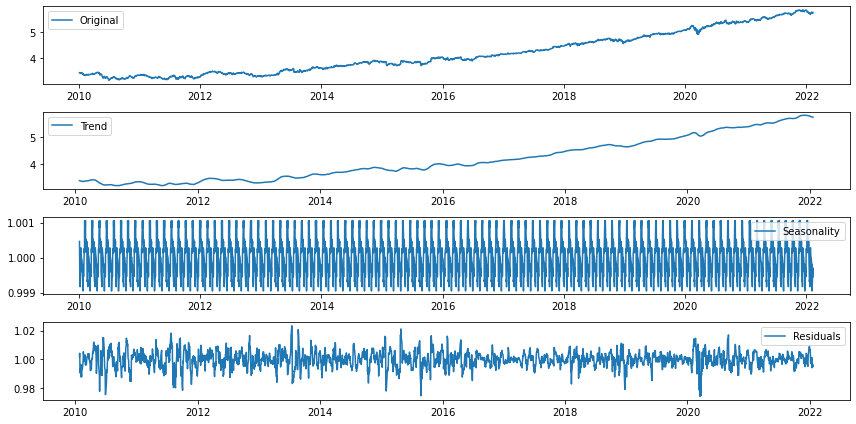

In [ ]:
# 시계열 분해
time_series_decomposition(ts_log)

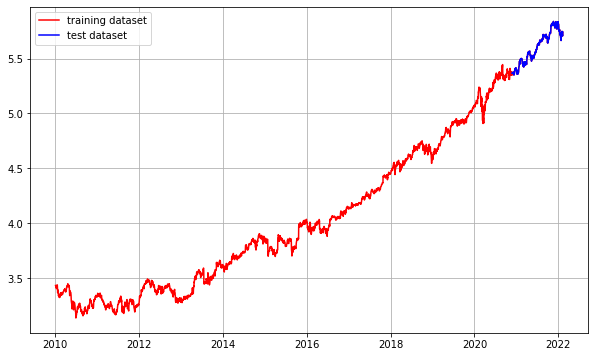

In [ ]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

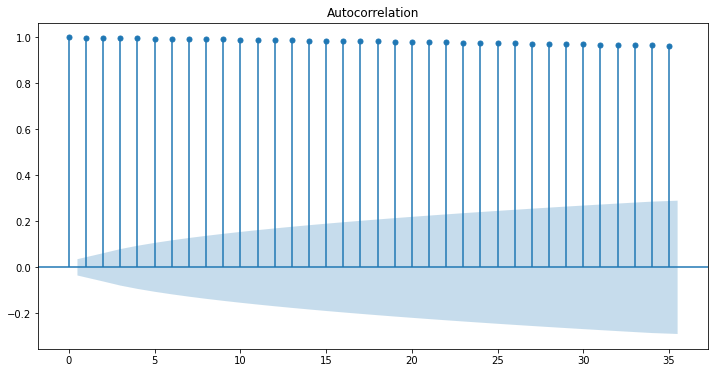

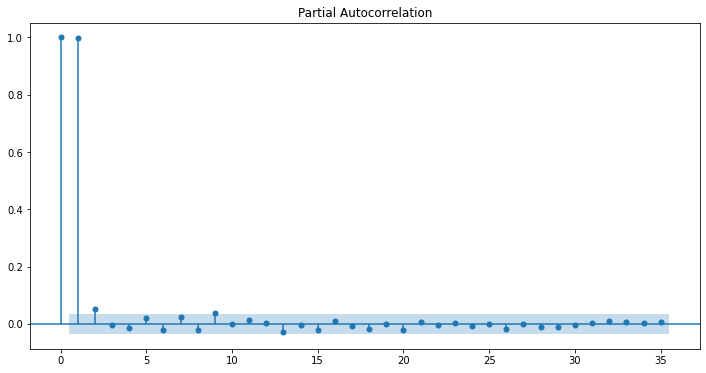

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.491209e+01
p-value                        1.453353e-27
#Lags Used                     1.400000e+01
Number of Observations Used    3.032000e+03
Critical Value (1%)           -3.432509e+00
Critical Value (5%)           -2.862494e+00
Critical Value (10%)          -2.567278e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.742110e+01
p-value                        4.825397e-30
#Lags Used                     2.800000e+01
Number of Observations Used    3.017000e+03
Critical Value (1%)           -3.432519e+00
Critical Value (5%)           -2.862498e+00
Critical Value (10%)          -2.567280e+00
dtype: float64


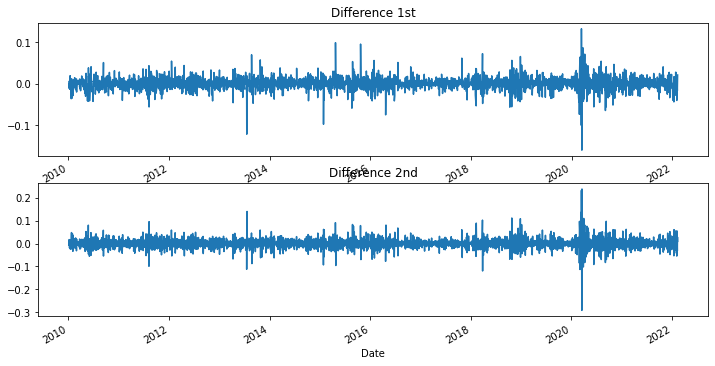

In [ ]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 2741
Model:                 ARIMA(1, 2, 3)   Log Likelihood                7455.794
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 10 Feb 2022   AIC                         -14899.589
Time:                        03:47:05   BIC                         -14864.092
Sample:                             2   HQIC                        -14886.762
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.135e-07   1.06e-06      0.676      0.499   -1.35e-06    2.78e-06
ar.L1.D2.Close    -0.9268      0.043    -21.711      0.000      -1.010      -0.843
ma.L1.D2.Close    -0.1505      0.047

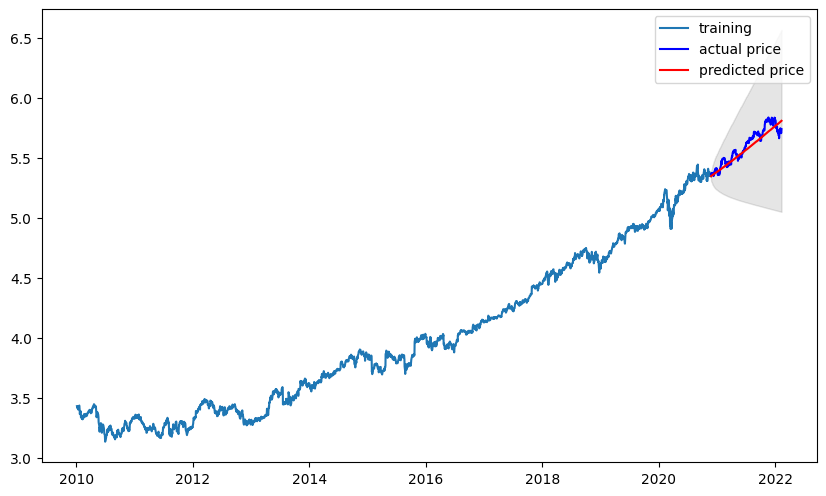

MSE:  255.02879149644295
MAE:  12.685067088310122
RMSE:  15.969620893948703
MAPE: 4.36%


In [ ]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 2, 3))

## 7-3. AMAZON

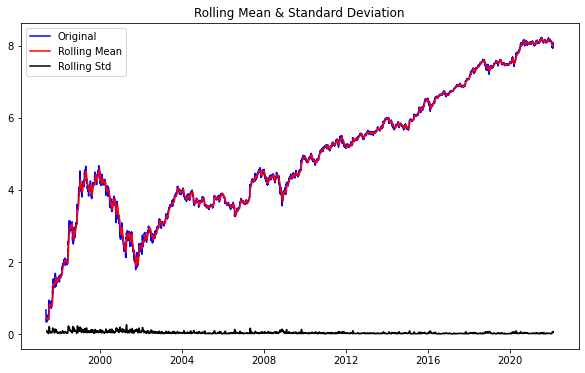

Results of Dickey-Fuller Test:
Test Statistic                   -1.697885
p-value                           0.432203
#Lags Used                       34.000000
Number of Observations Used    6192.000000
Critical Value (1%)              -3.431407
Critical Value (5%)              -2.862007
Critical Value (10%)             -2.567019
dtype: float64


In [ ]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('AMZN.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

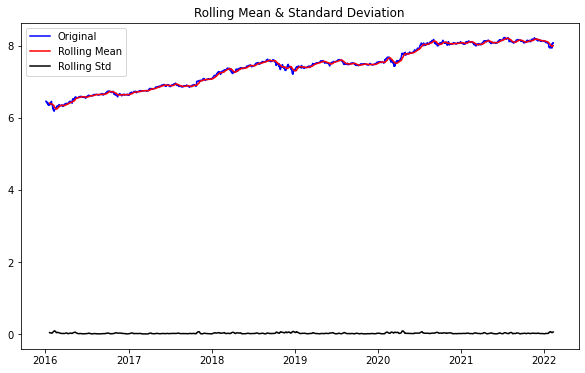

Results of Dickey-Fuller Test:
Test Statistic                   -1.365612
p-value                           0.598647
#Lags Used                        8.000000
Number of Observations Used    1529.000000
Critical Value (1%)              -3.434634
Critical Value (5%)              -2.863432
Critical Value (10%)             -2.567777
dtype: float64


In [ ]:
# 기간 조정
ts_log = ts_log['2016-01-01':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.195697e+01
p-value                        4.187742e-22
#Lags Used                     2.300000e+01
Number of Observations Used    1.484000e+03
Critical Value (1%)           -3.434764e+00
Critical Value (5%)           -2.863490e+00
Critical Value (10%)          -2.567808e+00
dtype: float64


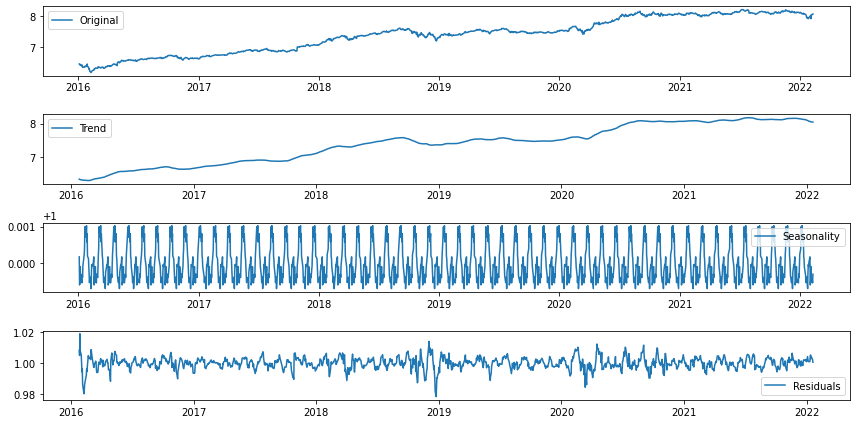

In [ ]:
# 시계열 분해
time_series_decomposition(ts_log)

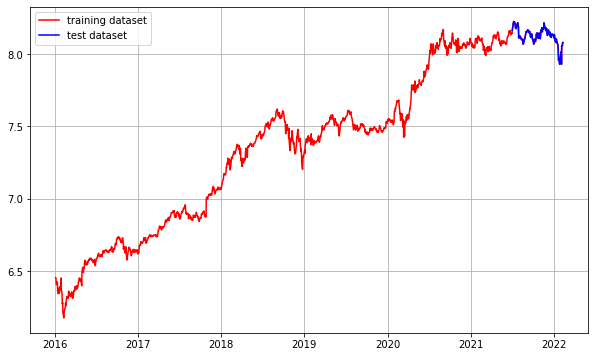

In [ ]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

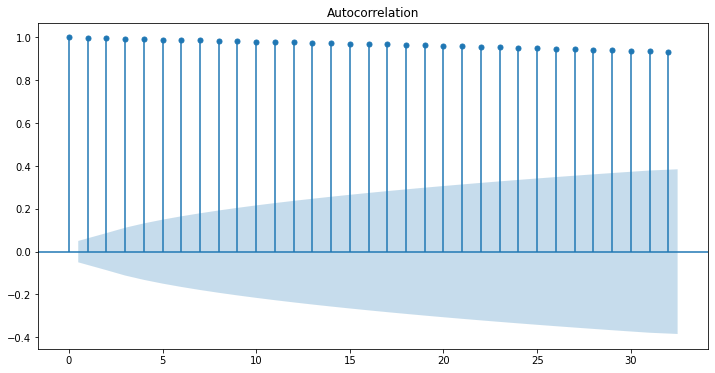

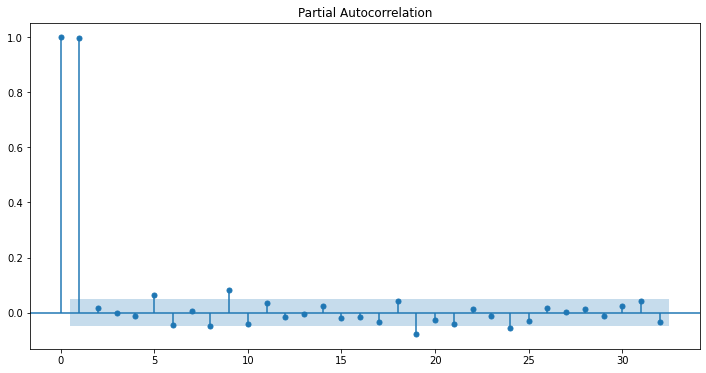

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.536102e+01
p-value                        3.612538e-28
#Lags Used                     7.000000e+00
Number of Observations Used    1.529000e+03
Critical Value (1%)           -3.434634e+00
Critical Value (5%)           -2.863432e+00
Critical Value (10%)          -2.567777e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.468809e+01
p-value                        3.080315e-27
#Lags Used                     2.100000e+01
Number of Observations Used    1.514000e+03
Critical Value (1%)           -3.434677e+00
Critical Value (5%)           -2.863451e+00
Critical Value (10%)          -2.567787e+00
dtype: float64


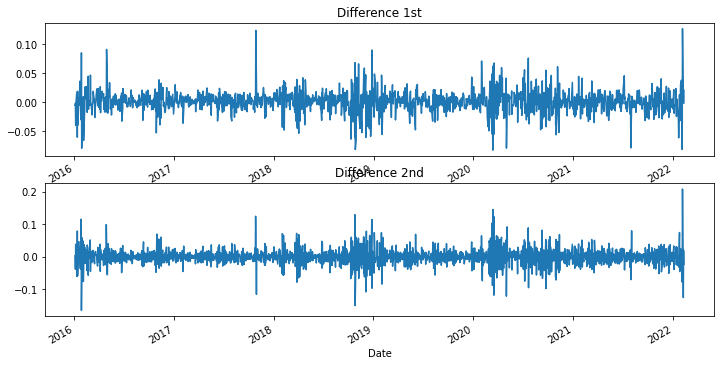

In [ ]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1383
Model:                 ARIMA(1, 1, 2)   Log Likelihood                3544.383
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 10 Feb 2022   AIC                          -7078.766
Time:                        03:47:09   BIC                          -7052.606
Sample:                             1   HQIC                         -7068.981
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.000      2.516      0.012       0.000       0.002
ar.L1.D.Close    -0.4255      0.312     -1.363      0.173      -1.037       0.186
ma.L1.D.Close     0.3725      0.312     

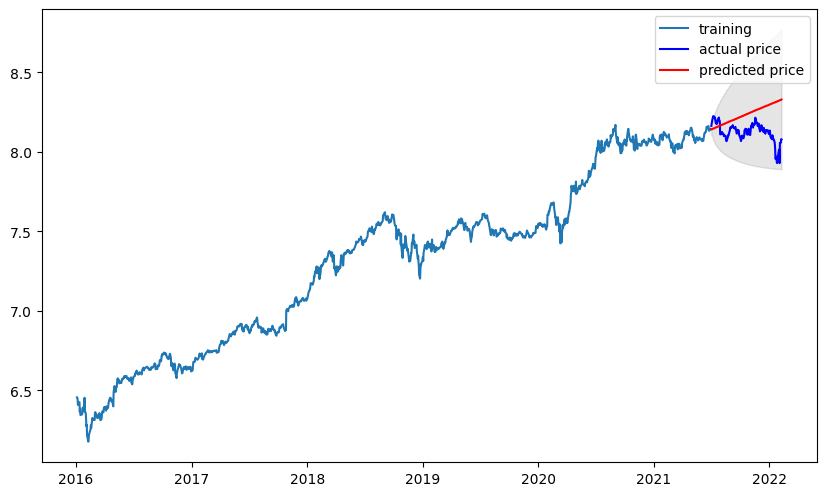

MSE:  281105.18929793313
MAE:  441.6910375087551
RMSE:  530.193539472081
MAPE: 13.56%


In [ ]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 1, 2))

## 7-4. TESLA

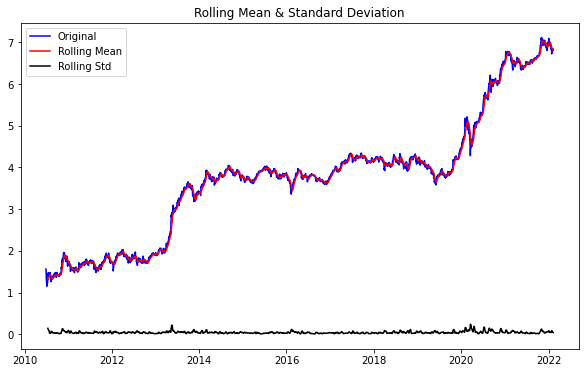

Results of Dickey-Fuller Test:
Test Statistic                    0.184552
p-value                           0.971382
#Lags Used                        0.000000
Number of Observations Used    2925.000000
Critical Value (1%)              -3.432588
Critical Value (5%)              -2.862529
Critical Value (10%)             -2.567296
dtype: float64


In [ ]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('TSLA.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

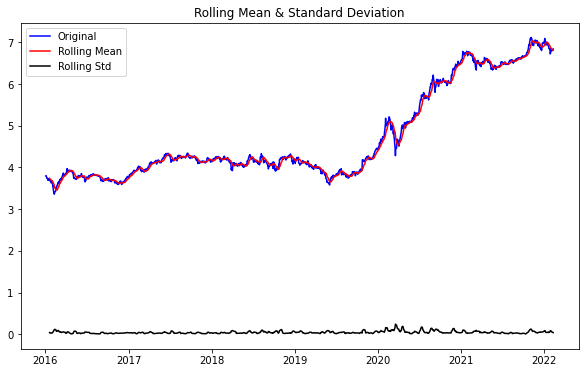

Results of Dickey-Fuller Test:
Test Statistic                    0.501079
p-value                           0.984906
#Lags Used                        0.000000
Number of Observations Used    1537.000000
Critical Value (1%)              -3.434612
Critical Value (5%)              -2.863422
Critical Value (10%)             -2.567772
dtype: float64


In [ ]:
# 기간 조정
ts_log = ts_log['2016-01-01':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.184344e+01
p-value                        7.495212e-22
#Lags Used                     1.800000e+01
Number of Observations Used    1.489000e+03
Critical Value (1%)           -3.434749e+00
Critical Value (5%)           -2.863483e+00
Critical Value (10%)          -2.567804e+00
dtype: float64


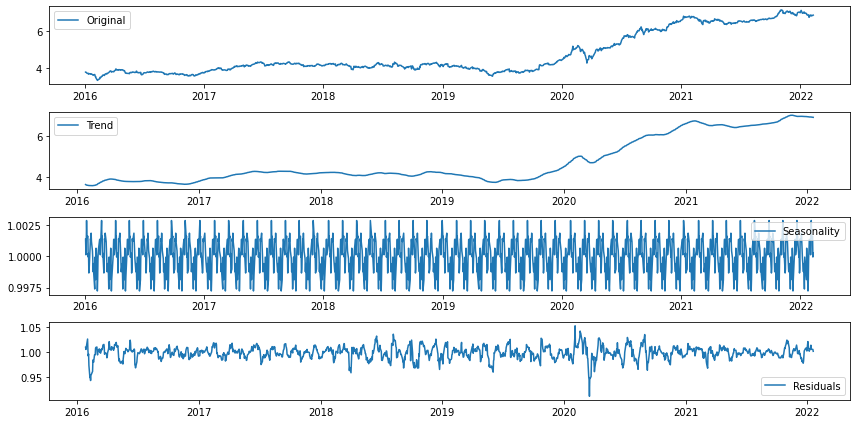

In [ ]:
# 시계열 분해
time_series_decomposition(ts_log)

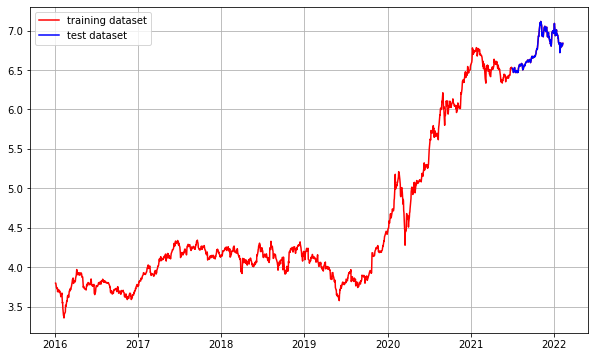

In [ ]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

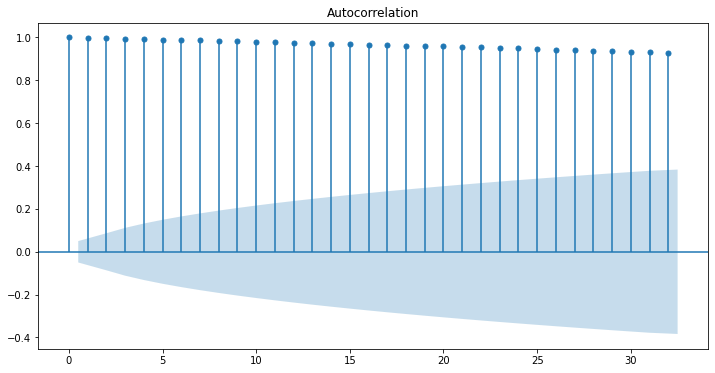

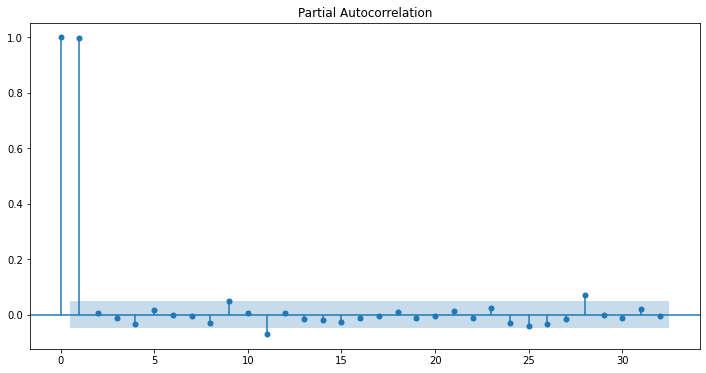

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                  -21.091442
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1534.000000
Critical Value (1%)              -3.434620
Critical Value (5%)              -2.863426
Critical Value (10%)             -2.567774
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.367008e+01
p-value                        1.465363e-25
#Lags Used                     2.300000e+01
Number of Observations Used    1.512000e+03
Critical Value (1%)           -3.434682e+00
Critical Value (5%)           -2.863453e+00
Critical Value (10%)          -2.567789e+00
dtype: float64


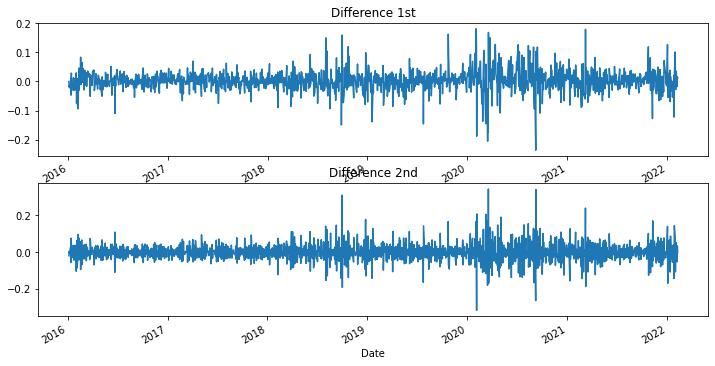

In [ ]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1382
Model:                 ARIMA(1, 2, 2)   Log Likelihood                2611.165
Method:                       css-mle   S.D. of innovations              0.037
Date:                Thu, 10 Feb 2022   AIC                          -5212.330
Time:                        03:47:12   BIC                          -5186.174
Sample:                             2   HQIC                         -5202.546
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            2.43e-06   9.84e-06      0.247      0.805   -1.68e-05    2.17e-05
ar.L1.D2.Close    -0.6499        nan        nan        nan         nan         nan
ma.L1.D2.Close    -0.3501        nan

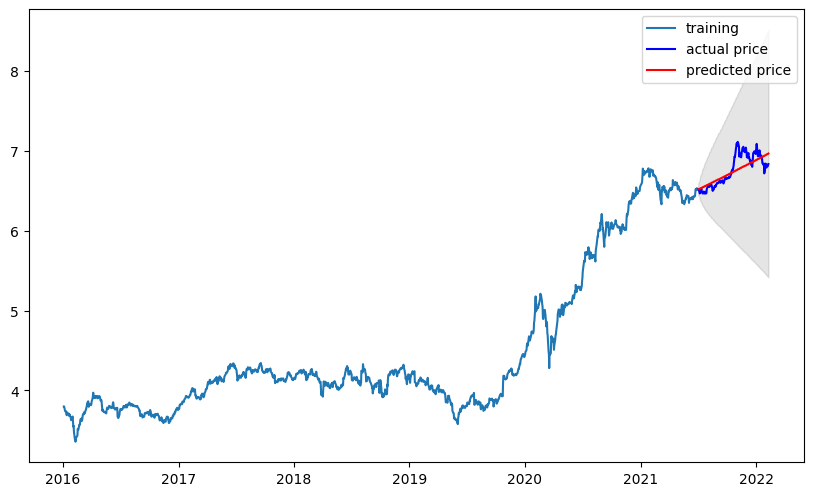

MSE:  13801.589189840148
MAE:  85.56317812066207
RMSE:  117.48016509113421
MAPE: 8.86%


In [ ]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 2, 2))

***
# 8. 프로젝트 정리
- MAPE를 낮출 수 있는 방법을 변동폭이 크지 않은 고민하다가 꾸준히 성장하면서 현재에도 계속 성장 중인 종목을 골랐다. 또한, 모든 데이터를 다 사용하지 않고 각 회사 별로 꾸준히 성장할정도의 안정되었을 시기의 데이터로 진행 하였다. MS-2010
AMZN,TSLA - 2016. 이 방법이 으로 MS - 5% 이하 AMZN,TSLA- 10% 이하로 종목의 MAPE를 낮추는 데 성공했다. 이것을 토대로 다량의 데이터 보다 안정된 구간의 데이터만 사용하는 것이 예측에 도움이 되는점을 알았다.